# Age Detection with Deep Learning convolutional neural network 

**An aim of the research** — process images and detect age of customers:
1. Pretrained ResNet50 model for classification on GPU using Keras
2. Ordinal Regression CNN algorithm on CPU using PyTorch
3. Multi-Classification CNN algorithm on CPU using PyTorch

**An initial data**

Data is taken from `APPA-REAL` database. In addition, `labels.csv` file is used to define targets for ML models.

Despite the size of images has already optimized some transformation and normalization are necessary to get modeling done in order to improve ML efficiency.
 
The research is divided into three steps:
  1. Data overview
  2. Image processing with Keras on GPU 
  3. Image processing with PyTorch on CPU:
  - Data pre-processing
  - Calculation of matrix sizes
  - Ordinal Regression CNN
  - Multi-Classification CNN 

### Step 1. Data overview

In [1]:
# import libriries
import torch as T
import torch.nn as nn
import torch.nn.functional as F
import torchvision.datasets
import torchvision.transforms as transforms
from torchvision.io import read_image
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision.utils import save_image
from torchvision.models import resnet50
from torchvision.transforms import Compose, ToTensor, Resize
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torch.utils.data import SubsetRandomSampler, WeightedRandomSampler

from tensorflow.keras import Sequential
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
from IPython.display import Image as disp_image
from sklearn.model_selection import train_test_split

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import os, sys

In [2]:
# set global parameters 
pd.set_option('precision', 2)
warnings.filterwarnings('ignore')

In [3]:
# reproducibility of results 
T.manual_seed(777)
np.random.seed(777)

In [6]:
# read in data file
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
# extract data from directory using data generator
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=777
) 

Found 7591 validated image filenames.


In [4]:
# iterate data through features and target
features, target = next(train_gen_flow)

In [9]:
# data shape
labels.shape

(7591, 2)

In [10]:
# show 5 rows
display(labels.head())

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


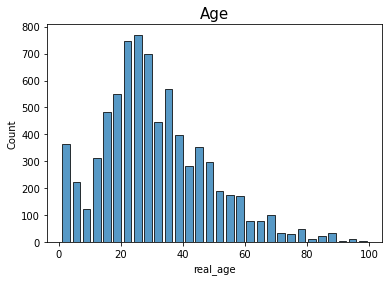

In [14]:
# distribusion of numerical variable 'real_age'
fig3, ax3 = plt.subplots()
sns.histplot(labels['real_age'], shrink=.75, bins=30, ax=ax3)
plt.title('Age', fontsize=15)
plt.show()

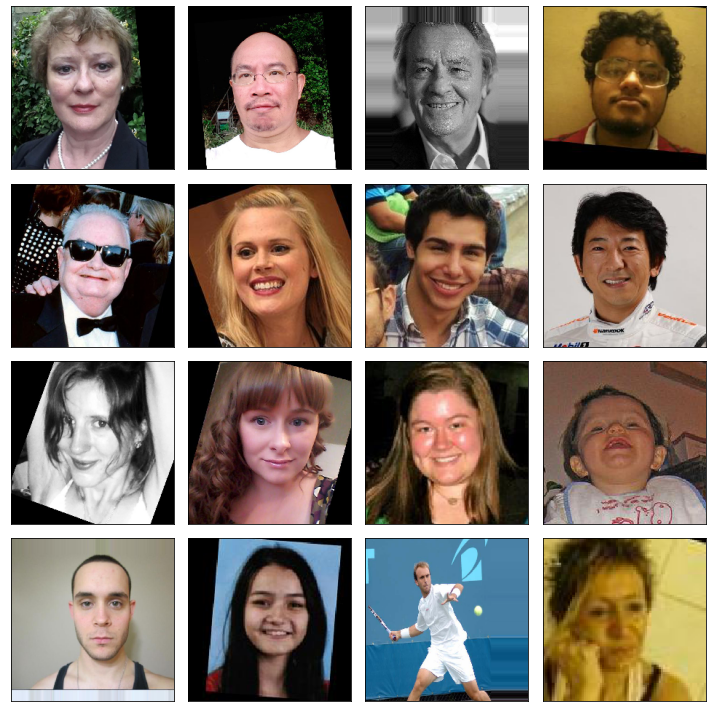

In [5]:
# print out features from dataset
fig = plt.figure(figsize=(10, 10))
for i in range(16):
    fig.add_subplot(4, 4, i + 1)
    plt.imshow(features[i])
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

Dataset consists of 7591 images of people aged between 0 and 100. With regard to distribution the majority is between 20 and 40 years old. Besides, there is labels.csv file that contains image names and corresponding ages.

### Step 2. Image processing with Keras

In [ ]:
# dataloader for training
def load_train(path):
    labels = pd.read_csv(path + '/labels.csv')
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    datagen_flow_train = train_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + '/final_files', 
        x_col='file_name', 
        y_col='real_age', 
        target_size=(224, 224), 
        batch_size=32, 
        class_mode='raw', 
        seed=777, 
        subset='training'
    )
    return datagen_flow_train

In [ ]:
# dataloader for testing
def load_test(path):
    labels = pd.read_csv(path + '/labels.csv')
    test_datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    
    datagen_flow_test = test_datagen.flow_from_dataframe(
        dataframe=labels, 
        directory=path + '/final_files', 
        x_col='file_name', 
        y_col='real_age', 
        target_size=(224, 224), 
        batch_size=32, 
        class_mode='raw', 
        seed=777, 
        subset='validation'
    )
    return datagen_flow_test

In [66]:
# # ResNet50 convolutional neural network
disp_image(url='https://miro.medium.com/max/720/0*tH9evuOFqk8F41FG.png', 
      width=650, height=260
)

In [ ]:
# keras model
def create_model(input_shape):
    backbone = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)
    optimizer = Adam(lr=0.0001)
    
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=1, activation='relu'))
    
    model.compile(
        loss='mean_absolute_error', 
        optimizer=optimizer, 
        metrics=['mean_absolute_error']
    )
    return model

In [55]:
# architecture of ResNet50
resnet50()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# training of keras model
def train_model(model, train_data, test_data, batch_size=None, epochs=10, 
                steps_per_epoch=None, validation_steps=None):
    
    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    
    model.fit(
        train_data, 
        validation_data=test_data, 
        batch_size=batch_size, 
        epochs=epochs, 
        steps_per_epoch=steps_per_epoch, 
        validation_steps=validation_steps, 
        verbose=2, 
        shuffle=True
    )
    return model

In [218]:
# GPU results
disp_image(url='https://cdn.hashnode.com/res/hashnode/image/upload/v1666727683371/ej_HjeL9X.PNG', 
      width=1000, height=700
)

Model uses pretrained layers of CNN so that weights are extracted from the existing file. Final layers include 'GlobalAveragePooling2D' to apply average pooling on the spatial dimensions until each spatial dimension is one, and leaves other dimensions unchanged. At the end there is one neuron with ReLu activation function to map data into range from 0 to Z.

With Adam optimizer and learning rate=0.0001, 10 epochs is enough to reach MAE=7.09. Elapsed time is around 10 minutes.

### Step 2. Image processing with PyTorch

#### Data pre-processing

In [4]:
# device parameters for pytorch model and root directory
device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
DATA_DIR = 'C:/YandexPracticumProjects/Project_14_ComputerVision_ML'

In [5]:
# directories for images and labels
csv_file = DATA_DIR + '/appa-real-release.csv' 
img_dir = DATA_DIR + '/appa-real-release/final_files'

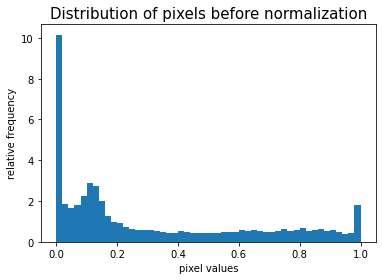

In [6]:
# load the image
img000001 = Image.open(img_dir + '/000001.jpg')

# define custom transform function
transform = transforms.Compose([ToTensor()])
 
# transform the pIL image to tensor image
img000001_tr = transform(img000001)
 
# convert tensor image to numpy array
img000001_np = np.array(img000001_tr)
 
# plot the pixel values
plt.hist(img000001_np.ravel(), bins=50, density=True)
plt.xlabel('pixel values')
plt.ylabel('relative frequency')
plt.title('Distribution of pixels before normalization', fontsize=15);

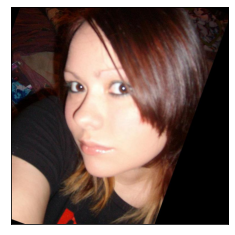

In [7]:
# display the original image
plt.imshow(img000001)
plt.xticks([])
plt.yticks([]);

In [8]:
# calculate mean and std
mean, std = img000001_tr.mean([1, 2]), img000001_tr.std([1, 2])
 
# print mean and std
print('mean and std before normalization:')
print('Mean of the image:', mean)
print('Std of the image:', std)

mean and std before normalization:
Mean of the image: tensor([0.3849, 0.2912, 0.2591])
Std of the image: tensor([0.3576, 0.3085, 0.2789])


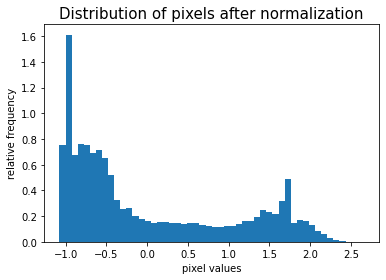

In [9]:
# define custom transform
transform_norm = transforms.Compose([
    transforms.ToTensor(), transforms.Normalize(mean, std)
])
 
# get normalized image
img000001_normalized = transform_norm(img000001)
 
# convert normalized image to numpy array
img000001_normalized_np = np.array(img000001_normalized)
 
# plot the pixel values
plt.hist(img000001_normalized_np.ravel(), bins=50, density=True)
plt.xlabel('pixel values')
plt.ylabel('relative frequency')
plt.title('Distribution of pixels after normalization', fontsize=15);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


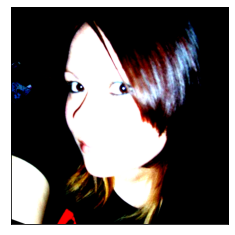

In [10]:
# convert this image to numpy array
img000001_norm_np = np.array(img000001_normalized)

# transpose from shape of (3,,) to shape of (,,3)
img000001_norm_final = img000001_norm_np.transpose(1, 2, 0)
 
# display the normalized image
plt.imshow(img000001_norm_final)
plt.xticks([])
plt.yticks([]);

In [11]:
# calculate mean and std of normalized image
mean_norm, std_norm = img000001_normalized.mean([1, 2]), img000001_normalized.std([1, 2])
 
# print mean and std
print('Mean and Std of normalized image:')
print('Mean of the image:', mean_norm)
print('Std of the image:', std_norm)

Mean and Std of normalized image:
Mean of the image: tensor([ 5.5409e-08, -2.8996e-08,  5.6055e-08])
Std of the image: tensor([1.0000, 1.0000, 1.0000])


Based on exploratry data analysis the optimal mean and standard deviation are defined. These values are then used to normalize the whole dataset.

In [12]:
# generate dataset of images and labels
class ImageDataset(Dataset):

    def __init__(self, csv_file, img_dir, transform=None):
        self.img_labels = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.transform = transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 1])
        image = Image.open(img_path)
        label = self.img_labels.iloc[idx, 2]
        
        if self.transform:
            image = self.transform(image)
        
        return (image, label) 

In [13]:
# transform images in train data
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0, hue=0.1),
    transforms.RandomCrop(224, 224),
    transforms.GaussianBlur(11, sigma=(0.1, 2.0)),
    transforms.RandomRotation(degrees=90),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.ToTensor(), 
    transforms.Normalize(mean, std) 
])    

In [14]:
# transform images in test data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])  

In [15]:
# sampling images for training and testing 
train_sampler = SubsetRandomSampler(list(range(1000)))
test_sampler = SubsetRandomSampler(list(range(200)))

In [16]:
# create train and test datasets
train_dataset = ImageDataset(csv_file, img_dir, transform=train_transform)
test_dataset = ImageDataset(csv_file, img_dir, transform=test_transform)

In [17]:
# data loaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=32, 
    sampler=train_sampler,
    shuffle=True,
    num_workers=0
)
test_loader = DataLoader(
    test_dataset, 
    batch_size=32, 
    sampler=test_sampler,
    shuffle=True,
    num_workers=0
)

In [18]:
# check for transformed images and labels
next(iter(train_loader))[0][0] 

tensor([[[-1.0765, -1.0765, -1.0765,  ..., -1.0765, -1.0765, -1.0765],
         [-1.0765, -1.0765, -1.0765,  ..., -1.0765, -1.0765, -1.0765],
         [-1.0765, -1.0765, -1.0765,  ..., -1.0765, -1.0765, -1.0765],
         ...,
         [-1.0765, -1.0765, -1.0765,  ..., -1.0765, -1.0765, -1.0765],
         [-1.0765, -1.0765, -1.0765,  ..., -1.0765, -1.0765, -1.0765],
         [-1.0765, -1.0765, -1.0765,  ..., -1.0765, -1.0765, -1.0765]],

        [[-0.9440, -0.9440, -0.9440,  ..., -0.9440, -0.9440, -0.9440],
         [-0.9440, -0.9440, -0.9440,  ..., -0.9440, -0.9440, -0.9440],
         [-0.9440, -0.9440, -0.9440,  ..., -0.9440, -0.9440, -0.9440],
         ...,
         [-0.9440, -0.9440, -0.9440,  ..., -0.9440, -0.9440, -0.9440],
         [-0.9440, -0.9440, -0.9440,  ..., -0.9440, -0.9440, -0.9440],
         [-0.9440, -0.9440, -0.9440,  ..., -0.9440, -0.9440, -0.9440]],

        [[-0.9291, -0.9291, -0.9291,  ..., -0.9291, -0.9291, -0.9291],
         [-0.9291, -0.9291, -0.9291,  ..., -0

In [19]:
# shape of 1st dimension
print('image, label data:', len(next(iter(train_loader))))

image, label data: 2


In [20]:
# shape of 2nd dimension
print('batch size:', len(next(iter(train_loader))[0]))

batch size: 32


In [21]:
# shape of 3rd dimension
print('number of channels:', len(next(iter(train_loader))[0][0]))

number of channels: 3


In [22]:
# shape of 4th dimension
print('number of pixels:', len(next(iter(train_loader))[0][0][0]))

number of pixels: 224


#### Main functions for training and testing

In [23]:
# initialize the weights 
def weights_init(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

In [24]:
# train the model
def training(model, dataloader, learn_rate, max_epoch, log_every, criterion, mode):
    optimizer = T.optim.Adam(model.parameters(), lr=learn_rate)

    train_result = [] 
    for epoch in range(max_epoch):
        
        iter_loss = 0              
        
        # model training
        model.train()
        for i, batch in enumerate(dataloader):
            X, y = batch              # (predictors, targets)         
            oupt = model(X.float())   # predicted age
            
            if mode == 'OR':
                loss = criterion(oupt, y.reshape(-1, 1).float())
            if mode == 'MC':
                loss = criterion(oupt, y)            
          
            iter_loss += loss.item()  # avg per item in batch

            optimizer.zero_grad()     # prepare gradients
            loss.backward()           # compute gradients
            optimizer.step()          # update weights

            if (epoch == max_epoch - 1):
                train_result.append((y, oupt.reshape(1, -1)[0]))    

        if (epoch % log_every == 0):
            print('Train: epoch: {0} | loss: {1:.2f}'.format(
                epoch, iter_loss / (i + 1)
                ))  

    return train_result         

In [25]:
# test the model
def testing(model, dataloader, max_epoch, log_every, criterion, mode):
    test_result = [] 
    for epoch in range(max_epoch):
        
        iter_loss = 0             
        
        # model testing
        model.eval()
        with T.no_grad():
            for i, batch in enumerate(dataloader):
                X, y = batch            # (predictors, targets)
                oupt = model(X.float()) # predicted values

                if mode == 'OR':
                    loss = criterion(oupt, y.reshape(-1, 1).float())
                if mode == 'MC':
                    loss = criterion(oupt, y) 

                iter_loss += loss       # avg per item in batch

                if (epoch == max_epoch - 1):
                    test_result.append((y, oupt.reshape(1, -1)[0]))

        if (epoch % log_every == 0):
            print('Train: epoch: {0} | loss: {1:.2f}'.format(
                epoch, iter_loss / (i + 1)
                ))  

    return test_result 

#### Calculation of matrix sizes

In [26]:
# I (ixi) - input dimensions of the image {3 @ 224 x 224}
# F (fxf) - size of filter/ kernel
# S (int) - strides
# P (int) - padding
# D (int) - depth/ number of feature maps/ activation maps
# [(I - F + 2 * P) / S] + 1 (@ D) - Convolution Output dimension
# [(I - F) / S] + 1 (@ D) - Pooling Output dimension 

In [27]:
# 1st layer of CNN
I1_conv = 224  # input dimensions of the image
F1_conv = 7    # size of filter/ kernel
S1_conv = 1    # strides
P1_conv = 1    # padding     
D1_conv = 32   # depth/ number of feature maps/ activation maps

F1_pool = 2    # size of filter/ kernel
S1_pool = 2    # strides

oupt1_conv = int(((I1_conv - F1_conv + 2 * P1_conv) / S1_conv) + 1)
print('conv1 output:', D1_conv, '@', oupt1_conv, 'x', oupt1_conv) 

oupt1_pool = int(((oupt1_conv - F1_pool) / S1_pool) + 1)
print('pool1 output:', D1_conv, '@', oupt1_pool, 'x', oupt1_pool) 

conv1 output: 32 @ 220 x 220
pool1 output: 32 @ 110 x 110


In [28]:
# 2nd layer of CNN
F2_conv = 7    # size of filter/ kernel
S2_conv = 1    # strides
P2_conv = 0    # padding     
D2_conv = 128  # depth/ number of feature maps/ activation maps

F2_pool = 2    # size of filter/ kernel
S2_pool = 2    # strides

oupt2_conv = int(((oupt1_pool - F2_conv + 2 * P2_conv) / S2_conv) + 1)
print('conv2 output:', D2_conv, '@', oupt2_conv, 'x', oupt2_conv)

oupt2_pool = int(((oupt2_conv - F2_pool) / S2_pool) + 1)
print('pool2 output:', D2_conv, '@', oupt2_pool, 'x', oupt2_pool) 

conv2 output: 128 @ 104 x 104
pool2 output: 128 @ 52 x 52


In [29]:
# 3rd layer of CNN
F3_conv = 3    # size of filter/ kernel
S3_conv = 1    # strides
P3_conv = 0    # padding     
D3_conv = 512  # depth/ number of feature maps/ activation maps

F3_pool = 2    # size of filter/ kernel
S3_pool = 2    # strides

oupt3_conv = int(((oupt2_pool - F3_conv + 2 * P3_conv) / S3_conv) + 1)
print('conv3 output:', D3_conv, '@', oupt3_conv, 'x', oupt3_conv)

oupt3_pool = int(((oupt3_conv - F3_pool) / S3_pool) + 1)
print('pool3 output:', D3_conv, '@', oupt3_pool, 'x', oupt3_pool) 

conv3 output: 512 @ 50 x 50
pool3 output: 512 @ 25 x 25


In [30]:
# set hyperparameters
LEARN_RATE = 0.001
MAX_EPOCH = 3
LOG_EVERY = 1

#### Ordinal Regression convolutional neural network

In [4]:
# Ordinal Regression convolutional neural network
disp_image(url='https://media.springernature.com/full/springer-static/image/art%3A10.1038%2Fs41467-021-23952-w/MediaObjects/41467_2021_23952_Fig1_HTML.png?as=webp', 
      width=800, height=450)

In [31]:
# define Ordinal Regression network
class Net_OR(nn.Module):
    def __init__(self):
        super(Net_OR, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, stride=1, kernel_size=7, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.MaxPool2d(stride=2, kernel_size=2), 
        ) 

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 128, stride=1, kernel_size=7, padding=0),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.MaxPool2d(stride=2, kernel_size=2), 
        )  

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 512, stride=1, kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.Tanh(),
            nn.MaxPool2d(stride=2, kernel_size=2), 
        )  

        self.fc = nn.Sequential(
            nn.Linear(512 * 25 * 25, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 1)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x) # 16x320000 @ 320000x1024
        x = T.sigmoid(x)
        return x

In [32]:
# create Ordinal Regression network
net_OR = Net_OR().to(device)

# apply initialized weights to the model forward pass
with T.no_grad():
    net_OR.apply(weights_init) 

# print out the net
net_OR    

Net_OR(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=320000, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_feat

In [33]:
# training results of Ordinal Regression model
train_result_OR = training(
    net_OR, train_loader, LEARN_RATE, MAX_EPOCH, LOG_EVERY, nn.MSELoss(), mode='OR'
)

Train: epoch: 0 | loss: 1054.14
Train: epoch: 1 | loss: 1055.59
Train: epoch: 2 | loss: 1045.08


In [34]:
# testing results of Ordinal Regression model
test_result_OR = testing(
    net_OR, test_loader, MAX_EPOCH, LOG_EVERY, nn.MSELoss(), mode='OR'
)

Train: epoch: 0 | loss: 1117.20
Train: epoch: 1 | loss: 1131.18
Train: epoch: 2 | loss: 1019.41


In [35]:
# ground truth values are in 1st list and predictions in 2nd
true_OR, pred_OR = zip(*test_result_OR)
true_OR, pred_OR = T.cat(true_OR), T.cat(pred_OR)

In [53]:
# size of the tensor
pred_OR.shape

torch.Size([200])

In [51]:
# prediction values (ages) in the range [0, 1] for 200 test samples
pred_OR 

tensor([0.7377, 0.9999, 0.3615, 1.0000, 0.9988, 0.0708, 1.0000, 0.9997, 1.0000,
        1.0000, 0.0297, 0.8872, 0.8980, 0.9858, 1.0000, 1.0000, 0.9996, 1.0000,
        1.0000, 0.9481, 0.0389, 0.0660, 0.9980, 1.0000, 1.0000, 1.0000, 0.0490,
        0.9929, 0.9652, 1.0000, 0.0813, 0.5470, 0.0809, 1.0000, 0.0101, 0.0672,
        0.2353, 0.9984, 0.9945, 0.9999, 1.0000, 0.7767, 0.1529, 1.0000, 0.8569,
        0.0660, 1.0000, 0.9999, 0.6922, 0.1063, 0.9998, 0.1828, 1.0000, 1.0000,
        1.0000, 0.2436, 0.0656, 0.0405, 0.0740, 0.0309, 1.0000, 0.9769, 0.0536,
        0.0702, 0.9846, 0.0581, 0.0628, 1.0000, 0.0514, 0.9900, 1.0000, 1.0000,
        1.0000, 0.9991, 0.9999, 0.0818, 0.0250, 0.2245, 1.0000, 1.0000, 1.0000,
        0.3932, 1.0000, 1.0000, 1.0000, 1.0000, 0.0223, 1.0000, 1.0000, 1.0000,
        1.0000, 0.0082, 0.9328, 0.9027, 0.9898, 1.0000, 1.0000, 1.0000, 0.0944,
        0.0653, 1.0000, 0.0133, 0.6287, 0.0249, 0.2514, 0.6419, 1.0000, 1.0000,
        1.0000, 0.9947, 0.0732, 0.9996, 

Neural network consists of three layers each of which has 4 sequential functions namely convolutional, batch normalization, tanh and max pooling. Last layer is also sequential with linear and tanh functions in order. One neuron at sigmoid function is used to calculate probabilities on each sample. Adam optimizer and MSE loss function are chosen for this net trained on CPU.

Due to tanh activation functions in convolutional layers and sigmoid function at the end after flattening, output is between 0 and 1 which corresponds to ages beween 0 and 100.

#### Multi-Classification  convolutional neural network

In [60]:
# Ordinal Regression convolutional neural network
disp_image(url='https://149695847.v2.pressablecdn.com/wp-content/uploads/2020/05/VGG19.png', 
      width=700, height=450)

In [36]:
# define Multi-Classification network
class Net_MC(nn.Module):
    def __init__(self):
        super(Net_MC, self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 32, stride=1, kernel_size=7, padding=1),
            nn.BatchNorm2d(32),
            nn.Tanh(),
            nn.MaxPool2d(stride=2, kernel_size=2), 
        ) 

        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 128, stride=1, kernel_size=7, padding=0),
            nn.BatchNorm2d(128),
            nn.Tanh(),
            nn.MaxPool2d(stride=2, kernel_size=2), 
        )  

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 512, stride=1, kernel_size=3, padding=0),
            nn.BatchNorm2d(512),
            nn.Tanh(),
            nn.MaxPool2d(stride=2, kernel_size=2), 
        )  

        self.fc = nn.Sequential(
            nn.Linear(512 * 25 * 25, 1024),
            nn.Tanh(),
            nn.Linear(1024, 512),
            nn.Tanh(),
            nn.Linear(512, 100)
        )

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = x.view(x.size(0), -1)
        x = self.fc(x) # 16x320000 @ 320000x1024
        return x  

In [37]:
# create Multi-Classification network
net_MC = Net_MC().to(device)

# apply initialized weights to the model forward pass
with T.no_grad():
    net_MC.apply(weights_init) 

# print out the net
net_MC  

Net_MC(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 128, kernel_size=(7, 7), stride=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(128, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): Tanh()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=320000, out_features=1024, bias=True)
    (1): Tanh()
    (2): Linear(in_features=1024, out_feat

In [38]:
# training results of Multi-Classification model
train_result_MC = training(
    net_MC, train_loader, LEARN_RATE, MAX_EPOCH, LOG_EVERY, nn.CrossEntropyLoss(), mode='MC'
)

Train: epoch: 0 | loss: 5.10
Train: epoch: 1 | loss: 4.68
Train: epoch: 2 | loss: 4.70


In [39]:
# testing results of Multi-Classification model
test_result_MC = testing(
    net_MC, test_loader, MAX_EPOCH, LOG_EVERY, nn.CrossEntropyLoss(), mode='MC'
)

Train: epoch: 0 | loss: 5.61
Train: epoch: 1 | loss: 5.57
Train: epoch: 2 | loss: 5.66


In [40]:
# ground truth values are in 1st list and predictions in 2nd
true_MC, pred_MC = zip(*test_result_MC)
true_MC, pred_MC = T.cat(true_MC), T.cat(pred_MC)

In [41]:
# extract tensors after testing the model
def extract_classes():    
    classes = []
    for data, label in test_loader:
        classes.append(net_MC(data))
    return classes 

In [52]:
# size of the tensor
extract_classes()[0][0].shape

torch.Size([100])

In [42]:
# probabilities of each class for the 1st image of the 1st batch
extract_classes()[0][0]

tensor([ 1.0954, -0.7520,  0.2696,  0.4439, -1.9409, -0.3975, -0.6307,  0.3020,
         1.0645, -0.4082,  0.4723,  0.4398,  1.7747, -1.0040,  0.0493, -0.8384,
        -0.1713, -1.2918, -1.2027, -1.1291, -1.4620, -0.2302, -1.0244, -0.5584,
        -0.9632, -1.5341, -2.3222, -1.3402, -1.6912,  0.6091, -1.8624,  0.6402,
        -0.3911, -0.6995, -1.0134, -1.2574, -0.9710, -0.3289, -0.0423,  0.0224,
        -0.7451, -0.4609, -0.5161, -0.9039,  0.1000, -0.5934, -0.0969,  0.1064,
        -0.1484, -1.4692, -0.8004, -0.6243,  0.2520,  0.5407, -0.4492,  1.1887,
         0.7349,  0.4597,  1.0591,  1.3359, -0.7874,  1.4741, -0.3047,  0.8706,
         0.6553,  0.2144,  0.6271,  0.8835, -0.0558,  0.3436,  0.5908,  1.2309,
        -0.4607,  0.9802,  1.1811, -0.9476,  1.0048,  0.8077,  1.0617,  1.7208,
        -0.6187,  0.9711,  0.8039,  1.2969,  0.9721,  0.0221,  1.2252,  1.4167,
         1.1447,  1.0437,  1.6537,  1.0888,  1.1054,  0.9634,  0.9266,  1.2709,
         1.5237,  0.8522,  1.2702,  1.37

This neural network for classification resambles the previous one for regression except the last layer. It is also sequential with linear and tanh functions in order but there are 100 neurons after linear activation. This is done because of 100 classes corresponding to range of ages. Adam optimizer and Cross Entropy loss function are chosen for this net trained on CPU as well. No soft max activation is needed in PySpark application.

As a result, 2d matrix of size=100 presented after classes extraction shows probabilities of each class (between 0 and 1) for the first image (for example).

### Conclusions

In order to detect age of customers based on dataset of facial images main ResNet50 model is used. It is only possible to run the model on GPU to render high-resolution images (224x224 pixels) and graphics focusing on concurrency, or breaking down complex tasks (lighting, shading, and textures modified at the pre-prodessing step) into smaller subtasks that are continuously performed in tandem. To do so, the model has already had pretrained weights. They are downloaded from remote repositories and helped converge the model with respect to loss function. Then only two additional layers have to be put at the end of the sequence (Global Average Pooling and ReLu activation function). Eventially, MAE metric reaches 7.09.

By contrast, CPU computation is performed on deep neural networks by constructing an appropriate architecture from scratch. Moreover, a random sampling method as a function of dataloader class has to be used to reduce the number of samples needed to run the model around 15-20 minutes. As a consequence, the size of train set is 1000 while test set is 200 images. Ordinal regression model demonstrates weak performance even when running for longer (MSE=1019.41 after 3 epochs). Multi-class classification shows better convergence (error=4.6) but loss function used is different - Cross Entropy.

To sum up, models hyper-parameters, architecture and computational results reveal significant aspects of CNN design. First of all, there must be enough convolutional layers for high-resolution images. Second, learning rate really matters and has to be somwhere between 0.01 and 0.0001, however taking into account computational time. Finally, matrix multiplication directly depends on their size, so that preliminary calculation is of main importance to build a reliable ML model.